# Finals
## Prob. 2

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

$
d\omega = 0
$

$
\phi = 0
$

$
\Omega \times V_{0} = 1
$

$
\Delta t = 0.001
$

$
U(t=0) = 
\begin{pmatrix}
1 & 0 \\
0 & 1 \\
\end{pmatrix}
$

In [45]:
dw12 = 0.
dw1 = 0.
dw2 = 0.
phi1 = 0.
phi2 = 0.
om_v0 = 1
dt = 0.001

u0 = torch.tensor([[1, 0, 0, 0], 
                   [0, 1, 0, 0], 
                   [0, 0, 1, 0], 
                   [0, 0, 0, 1]]) * (1. + 0j)

$
H(t) = -\frac{1}{2} \Omega V_{0} s(t) 
\begin{pmatrix}
0                        & e^{i(\text{d} \omega t + \phi)} \\
e^{-i(\text{d} \omega t + \phi)} & 0                       \\
\end{pmatrix}
$

In [46]:
def H(g_t, s1_t, s2_t, T):

    t = T*dt
    y =(g_t * torch.tensor([[0, 0, 0, 0],
                            [0, 0, torch.exp(torch.tensor(-1j * (dw12*t))),0],
                            [0, torch.exp(torch.tensor(1j*(dw12*t ))), 0, 0],
                            [0, 0, 0, 0]])
        -0.5 * om_v0 * s1_t * torch.tensor([[0, 0, torch.exp(torch.tensor( 1j * (dw1*t + phi1))), 0],
                                            [0, 0, 0, torch.exp(torch.tensor( 1j * (dw1*t + phi1)))],
                                            [torch.exp(torch.tensor(-1j * (dw1*t + phi1))), 0, 0, 0],
                                            [0, torch.exp(torch.tensor(-1j * (dw1*t + phi1))), 0, 0]])
        -0.5 * om_v0 * s2_t * torch.tensor([[0, torch.exp(torch.tensor( 1j * (dw2*t + phi2))), 0 ,0],
                                            [torch.exp(torch.tensor(-1j * (dw2*t + phi2))), 0, 0, 0],
                                            [0, 0, 0, torch.exp(torch.tensor( 1j * (dw2*t + phi2)))],
                                            [0, 0, torch.exp(torch.tensor(-1j * (dw2*t + phi2))), 0]]))
    return y

In [47]:
input_size = 64
hidden_layer_overlaps = 3

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        layers = []
        in_features = input_size * 8
        last_in_features = in_features
        out_features = input_size * 16

        for _ in range(hidden_layer_overlaps):
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            in_features = out_features
            out_features //= 2  # 출력 차원 줄이는 정도 (=나누기 2)
        layers.append(nn.Linear(in_features, last_in_features))  # last layer  # input_size*1

        self.fcn = nn.Sequential(*layers)  # Fully Connected Network

    def forward(self, x):
        y = self.fcn(x)
        return y

$
P = \big|
\begin{pmatrix}
0 & 1 \\
\end{pmatrix}
U(t)
\begin{pmatrix}
1 \\
0 \\
\end{pmatrix}
\big| ^2
$

tensor([22.7260], grad_fn=<AddBackward0>)
tensor([22.6774], grad_fn=<AddBackward0>)
tensor([22.6328], grad_fn=<AddBackward0>)
tensor([22.5917], grad_fn=<AddBackward0>)
tensor([22.5537], grad_fn=<AddBackward0>)
tensor([22.5181], grad_fn=<AddBackward0>)
tensor([22.4845], grad_fn=<AddBackward0>)
tensor([22.4523], grad_fn=<AddBackward0>)
tensor([22.4219], grad_fn=<AddBackward0>)
tensor([22.3929], grad_fn=<AddBackward0>)
tensor([22.3646], grad_fn=<AddBackward0>)
tensor([22.3374], grad_fn=<AddBackward0>)
tensor([22.3111], grad_fn=<AddBackward0>)
tensor([22.2852], grad_fn=<AddBackward0>)
tensor([22.2600], grad_fn=<AddBackward0>)
tensor([22.2352], grad_fn=<AddBackward0>)
tensor([22.2107], grad_fn=<AddBackward0>)
tensor([22.1865], grad_fn=<AddBackward0>)
tensor([22.1624], grad_fn=<AddBackward0>)
tensor([22.1385], grad_fn=<AddBackward0>)
tensor([22.1147], grad_fn=<AddBackward0>)
tensor([22.0910], grad_fn=<AddBackward0>)
tensor([22.0673], grad_fn=<AddBackward0>)
tensor([22.0434], grad_fn=<AddBack

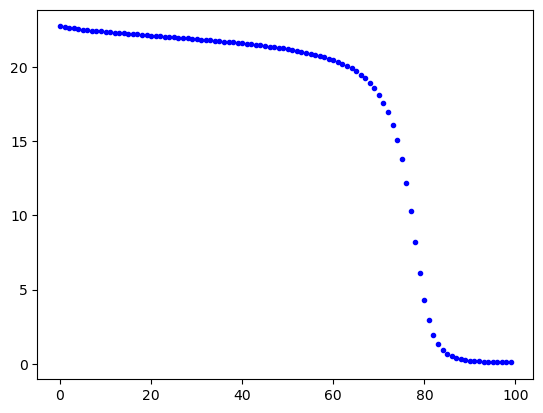

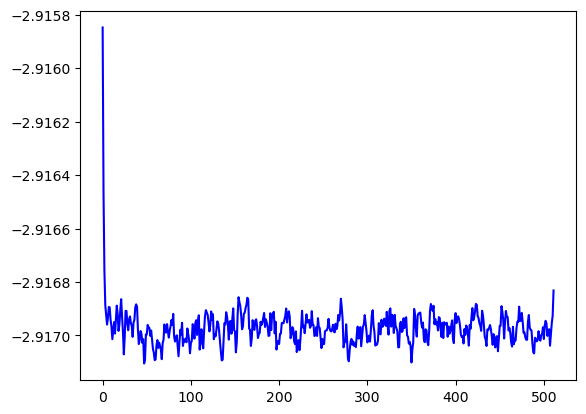

tensor([[ 1.0000e+00+9.7285e-08j, -2.6520e-04-1.7477e-04j,
          5.3947e-04+2.1809e-04j,  1.8647e-07-3.8563e-08j],
        [-1.9550e-04-5.5141e-04j,  8.0315e-02+1.7757e-07j,
          1.1298e-07+9.9895e-01j,  1.2909e-04+2.8213e-04j],
        [ 1.2909e-04+2.8213e-04j,  1.1298e-07+9.9895e-01j,
          8.0315e-02+1.7757e-07j, -1.9550e-04-5.5141e-04j],
        [ 1.8647e-07-3.8563e-08j,  5.3947e-04+2.1809e-04j,
         -2.6520e-04-1.7477e-04j,  1.0000e+00+9.7285e-08j]],
       grad_fn=<AddBackward0>)


In [48]:
learning_rate = 1e-3

model_g = NeuralNet()
model_s1 = NeuralNet()
model_s2 = NeuralNet()
optimizer_g = torch.optim.SGD(model_g.parameters(), lr=learning_rate)  # lr = learning rate
optimizer_s1 = torch.optim.SGD(model_s1.parameters(), lr=learning_rate)
optimizer_s2 = torch.optim.SGD(model_s2.parameters(), lr=learning_rate)

loss_list = []
list_g = []
list_s1 = []
list_s2 = []

epoch_range = 1000+1
export_epoch = 10
T_size = input_size * 8

for epoch in range(epoch_range):
    input_t = torch.arange(T_size) * dt
    gt = model_g(input_t)
    s1t = model_s1(input_t)
    s2t = model_s2(input_t)
    model_g.train()
    model_s1.train()
    model_s2.train()

    ut = u0.detach().clone()

    for T in range(1, T_size):
        dudt = -1j * torch.matmul(H(gt[T], s1t[T], s2t[T], T), ut)
        ut = ut + dudt*dt
    
    p1 = (torch.matmul(torch.matmul(torch.tensor([[0, 1, 0, 0]]) * (1. + 0j), ut), torch.tensor([[0], [1], [0], [0]])*(1. + 0j)))[0]
    p2 = (torch.matmul(torch.matmul(torch.tensor([[0, 1, 0, 0]]) * (1. + 0j), ut), torch.tensor([[0], [0], [1], [0]])*(1. + 0j)) - 1j)[0]
    p3 = (torch.matmul(torch.matmul(torch.tensor([[0, 0, 1, 0]]) * (1. + 0j), ut), torch.tensor([[0], [1], [0], [0]])*(1. + 0j)) - 1j)[0]
    p4 = (torch.matmul(torch.matmul(torch.tensor([[0, 0, 1, 0]]) * (1. + 0j), ut), torch.tensor([[0], [0], [1], [0]])*(1. + 0j)))[0]

    loss = (+  1 * (torch.square(np.imag(p1)) + torch.square(np.real(p1))).requires_grad_(True)
            + 10 * (torch.square(np.real(p2)) + torch.square(np.imag(p2))).requires_grad_(True) 
            + 10 * (torch.square(np.real(p3)) + torch.square(np.imag(p3))).requires_grad_(True) 
            +  1 * (torch.square(np.imag(p4)) + torch.square(np.real(p4))).requires_grad_(True)
            +0.1 * torch.sum((torch.diff(gt )**2) + torch.sum(torch.var(gt ))).requires_grad_(True) 
            +0.1 * torch.sum((torch.diff(s1t)**2) + torch.sum(torch.var(s1t))).requires_grad_(True) 
            +0.1 * torch.sum((torch.diff(s2t)**2) + torch.sum(torch.var(s2t))).requires_grad_(True))
    
    loss.backward()
    optimizer_g.step()
    optimizer_s1.step()
    optimizer_s2.step()
    optimizer_g.zero_grad()
    optimizer_s1.zero_grad()
    optimizer_s2.zero_grad()

    if epoch % export_epoch == 1:  # export_epoch = 10
        print(loss)
        # print(ut)
        # plt.plot(st.detach().numpy(), 'b')
        # plt.show()
        loss_list.append(loss.item())
        list_s1.append(str(loss.item()))

plt.plot(loss_list, 'b.')
plt.show()

plt.plot(gt.detach().numpy(), 'b')
plt.show()
print(ut)

In [49]:
z = 1 - 3j
print(np.imag(z))
print(torch.square(torch.matmul(torch.matmul(torch.tensor([[0, 1, 0, 0]]) * (1. + 0j), ut), torch.tensor([[0], [0], [1], [0]])*(1. + 0j))))

-3.0
tensor([[-0.9979+2.2573e-07j]], grad_fn=<PowBackward0>)


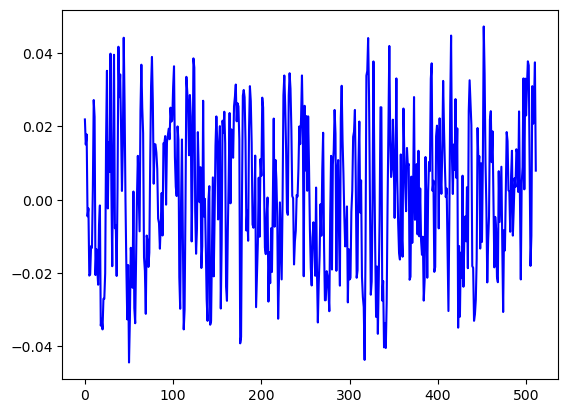

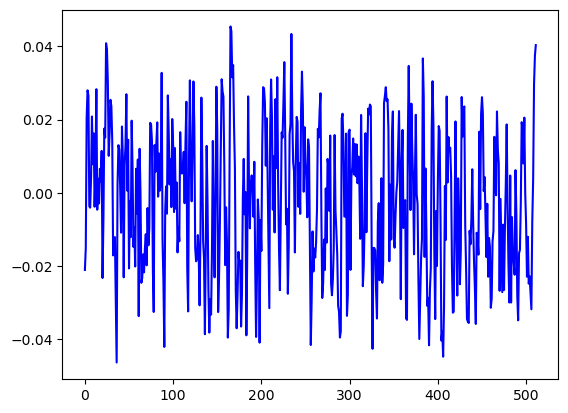

In [50]:
plt.plot(s1t.detach().numpy(), 'b')
plt.show()
plt.plot(s2t.detach().numpy(), 'b')
plt.show()